<div align="center"> 
    <hr>
  <font size="6"><b>Dev | Clean-Clean Entity Resolution Notebook</b> </font>
   <hr>
</div>

In [ ]:
!python --version

In [8]:
import os
import sys
import pandas as pd
import networkx
from networkx import draw, Graph
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
from pyjedai.utils import (
    text_cleaning_method,
    print_clusters,
    print_blocks,
    print_candidate_pairs
)
from pyjedai.evaluation import Evaluation, write
from pyjedai.datamodel import Data
d1 = pd.read_csv("./data/ccer/D2/abt.csv", sep='|', engine='python', na_filter=False).astype(str)
d2 = pd.read_csv("./data/ccer/D2/buy.csv", sep='|', engine='python', na_filter=False).astype(str)
gt = pd.read_csv("./data/ccer/D2/gt.csv", sep='|', engine='python')

data = Data(
    dataset_1=d1,
    attributes_1=['id','name','description'],
    id_column_name_1='id',
    dataset_2=d2,
    attributes_2=['id','name','description'],
    id_column_name_2='id',
    ground_truth=gt,
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Block Building

In [9]:
from pyjedai.block_building import (
    StandardBlocking,
    QGramsBlocking,
    ExtendedQGramsBlocking,
    SuffixArraysBlocking,
    ExtendedSuffixArraysBlocking,
)

from pyjedai.vector_based_blocking import EmbeddingsNNBlockBuilding

C:\Users\nikol\Desktop\GitHub\pyJedAI-Dev\pyjedai\block_building.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [10]:
qgb = SuffixArraysBlocking()
blocks = qgb.build_blocks(data, attributes_1=['name'], attributes_2=['name'])

Suffix Arrays Blocking:   0%|          | 0/2152 [00:00<?, ?it/s]

In [5]:
qgb.report()

Method name: Suffix Arrays Blocking
Method info: Creates one block for every suffix that appears in the attribute value tokens of at least two entities.
Parameters: 
	Suffix length: 6
	Maximum Block Size: 53
Attributes from D1:
	name
Attributes from D2:
	name
Runtime: 0.1585 seconds


In [6]:
e = Evaluation(data)
e.report(blocks, qgb.method_configuration())

# Suffix Arrays Blocking Evaluation 
---
Method name: Suffix Arrays Blocking
Parameters: 
	Suffix length: 6
	Maximum Block Size: 53
Runtime: 0.1585 seconds
Scores:
	Precision:      1.41% 
	Recall:        97.03%
	F1-score:       2.78%
Classification report:
	True positives: 1044
	False positives: 73021
	True negatives: 1084723
	False negatives: 32
	Total comparisons: 74065
---


#### EmbeddingsNNBlockBuilding

In [8]:
emb = EmbeddingsNNBlockBuilding(
    vectorizer='bert',
    similarity_search='faiss'
)
blocks = emb.build_blocks(data)

Embeddings-NN Block Building:   0%|          | 0/2152 [00:00<?, ?it/s]

In [ ]:
Evaluation(data).report(blocks, emb.method_configuration())

# Block Cleaning

In [11]:
from pyjedai.block_cleaning import BlockFiltering

In [12]:
bf = BlockFiltering(ratio=0.8)
filtered_blocks = bf.process(blocks, data, tqdm_disable=False)

Block Filtering:   0%|          | 0/3 [00:00<?, ?it/s]

In [13]:
Evaluation(data).report(filtered_blocks, bf.method_configuration())

# Block Filtering Evaluation 
---
Method name: Block Filtering
Parameters: 
	Ratio: 0.8
Runtime: 0.0441 seconds
Scores:
	Precision:      2.81% 
	Recall:        94.52%
	F1-score:       5.45%
---


# Comparison Cleaning


In [14]:
from pyjedai.block_cleaning import BlockPurging

In [15]:
cbbp = BlockPurging()
cleaned_blocks = cbbp.process(filtered_blocks, data, tqdm_disable=False)

Block Purging:   0%|          | 0/5818 [00:00<?, ?it/s]

In [12]:
cbbp.report()

Method name: Block Purging
Method info: Discards the blocks exceeding a certain number of comparisons.
Parameters: 
	Smoothing factor: 1.025
	Max Comparisons per Block: 420.0
Runtime: 0.0335 seconds


In [16]:
e = Evaluation(data)
e.report(cleaned_blocks, cbbp.method_configuration())

# Block Purging Evaluation 
---
Method name: Block Purging
Parameters: 
	Smoothing factor: 1.025
	Max Comparisons per Block: 420.0
Runtime: 0.0528 seconds
Scores:
	Precision:      2.81% 
	Recall:        94.52%
	F1-score:       5.45%
---


## Meta Blocking

In [17]:
from pyjedai.comparison_cleaning import (
    WeightedEdgePruning,
    WeightedNodePruning,
    CardinalityEdgePruning,
    CardinalityNodePruning,
    BLAST,
    ReciprocalCardinalityNodePruning,
    ReciprocalWeightedNodePruning,
    ComparisonPropagation
)

In [18]:
wep = CardinalityEdgePruning(weighting_scheme='X2')
candidate_pairs_blocks = wep.process(filtered_blocks, data, tqdm_disable=True)

In [19]:
Evaluation(data).report(candidate_pairs_blocks, wep.method_configuration())

# Cardinality Edge Pruning Evaluation 
---
Method name: Cardinality Edge Pruning
Parameters: 
	Node centric: False
	Weighting scheme: X2
Runtime: 0.6490 seconds
Scores:
	Precision:     13.44% 
	Recall:        89.13%
	F1-score:      23.35%
---


# Entity Matching

It compares pairs of entity profiles, associating every pair with a similarity in [0,1]. Its output comprises the similarity graph, i.e., an undirected, weighted graph where the nodes correspond to entities and the edges connect pairs of compared entities.

In [20]:
from pyjedai.matching import EntityMatching

In [29]:
EM = EntityMatching(
    metric='dice',
    similarity_threshold=0.4,
    attributes = ['description', 'name']
)

pairs_graph = EM.predict(candidate_pairs_blocks, data, tqdm_disable=True)

In [27]:
# pairs = write(pairs_graph, data)

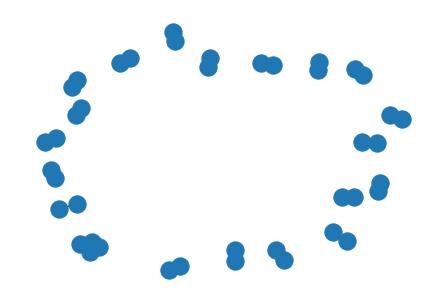

In [23]:
draw(pairs_graph)

In [30]:
Evaluation(data).report(pairs_graph, EM.method_configuration())

# Entity Matching Evaluation 
---
Method name: Entity Matching
Parameters: 
	Metric: dice
	Embeddings: None
	Attributes: ['description', 'name']
	Similarity threshold: 0.4
Runtime: 1.8867 seconds
Scores:
	Precision:     72.09% 
	Recall:        20.17%
	F1-score:      31.52%
---


# Entity Clustering

It takes as input the similarity graph produced by Entity Matching and partitions it into a set of equivalence clusters, with every cluster corresponding to a distinct real-world object.

In [36]:
from pyjedai.clustering import ConnectedComponentsClustering, UniqueMappingClustering

In [32]:
ccc = ConnectedComponentsClustering()
clusters = ccc.process(pairs_graph)

In [33]:
ccc.report()

Method name: Connected Components Clustering
Method info: Gets equivalence clusters from the transitive closure of the similarity graph.
Runtime: 0.0010 seconds


In [34]:
Evaluation(data).report(clusters)

#  Evaluation 
---
Scores:
	Precision:     62.32% 
	Recall:        20.45%
	F1-score:      30.79%
---


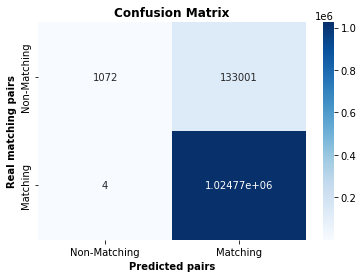

In [34]:
e.confusion_matrix()

In [64]:
from pyjedai.clustering import ConnectedComponentsClustering, UniqueMappingClustering
umc = UniqueMappingClustering()
clusters = umc.process(pairs_graph)

In [66]:
Evaluation(data).report(clusters)

#  Evaluation 
---
Scores:
	Precision:     85.40% 
	Recall:        17.94%
	F1-score:      29.65%
---
